# Project Description

<br>

**Project Objective:** The objective is to perform binary classification on the tweets from airline passengers in US for six different airlines. The classes are
1. **Neutral**
2. **Non-Neutral**

Originaly, the dataset contains three different classes, **you may have to merge the positive and negative class in a single class**.

**Dataset**: [Kaggle: Twitter US Airline Sentiment](https://www.kaggle.com/crowdflower/twitter-airline-sentiment)

This data set contains roughly 15K tweets with 3 possible classes for the sentiment (positive, negative and neutral). The data has been already cleaned from the original format, but you can further clean the data if it can increases the accuracy of the model. 

Here, you are advised to start with basic model and then use any pre-trained word embedding method such as word2vec, GloVe, FastText to compare the results.



In [0]:
# You can download the dataset using (please uncomment to download)
!wget "https://www.dropbox.com/s/ky0e7xcdv2erree/Tweets.csv"
!ls -la

--2019-09-29 09:21:06--  https://www.dropbox.com/s/ky0e7xcdv2erree/Tweets.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ky0e7xcdv2erree/Tweets.csv [following]
--2019-09-29 09:21:06--  https://www.dropbox.com/s/raw/ky0e7xcdv2erree/Tweets.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc8fbb00263dc5b708b05afb383.dl.dropboxusercontent.com/cd/0/inline/ApdqDxcMWh72fQ2uqT3O6NherRsgbUw3M22cYYGpySS-7qFKV8qIVkXEufvivLySoNOf8AnjCb3KPJc7NOOR2oO8wBjJ7cn_2srAn7lCvcDRKhkKBRs_B2Cxw_6SM4SnH3s/file# [following]
--2019-09-29 09:21:06--  https://ucc8fbb00263dc5b708b05afb383.dl.dropboxusercontent.com/cd/0/inline/ApdqDxcMWh72fQ2uqT3O6NherRsgbUw3M22cYYGpySS-7qFKV8qIVkXEufvivLySoNOf8AnjCb3KPJc7NOOR2oO8wBjJ7cn_2srAn7lCvcDRKhkKBRs_B2Cx

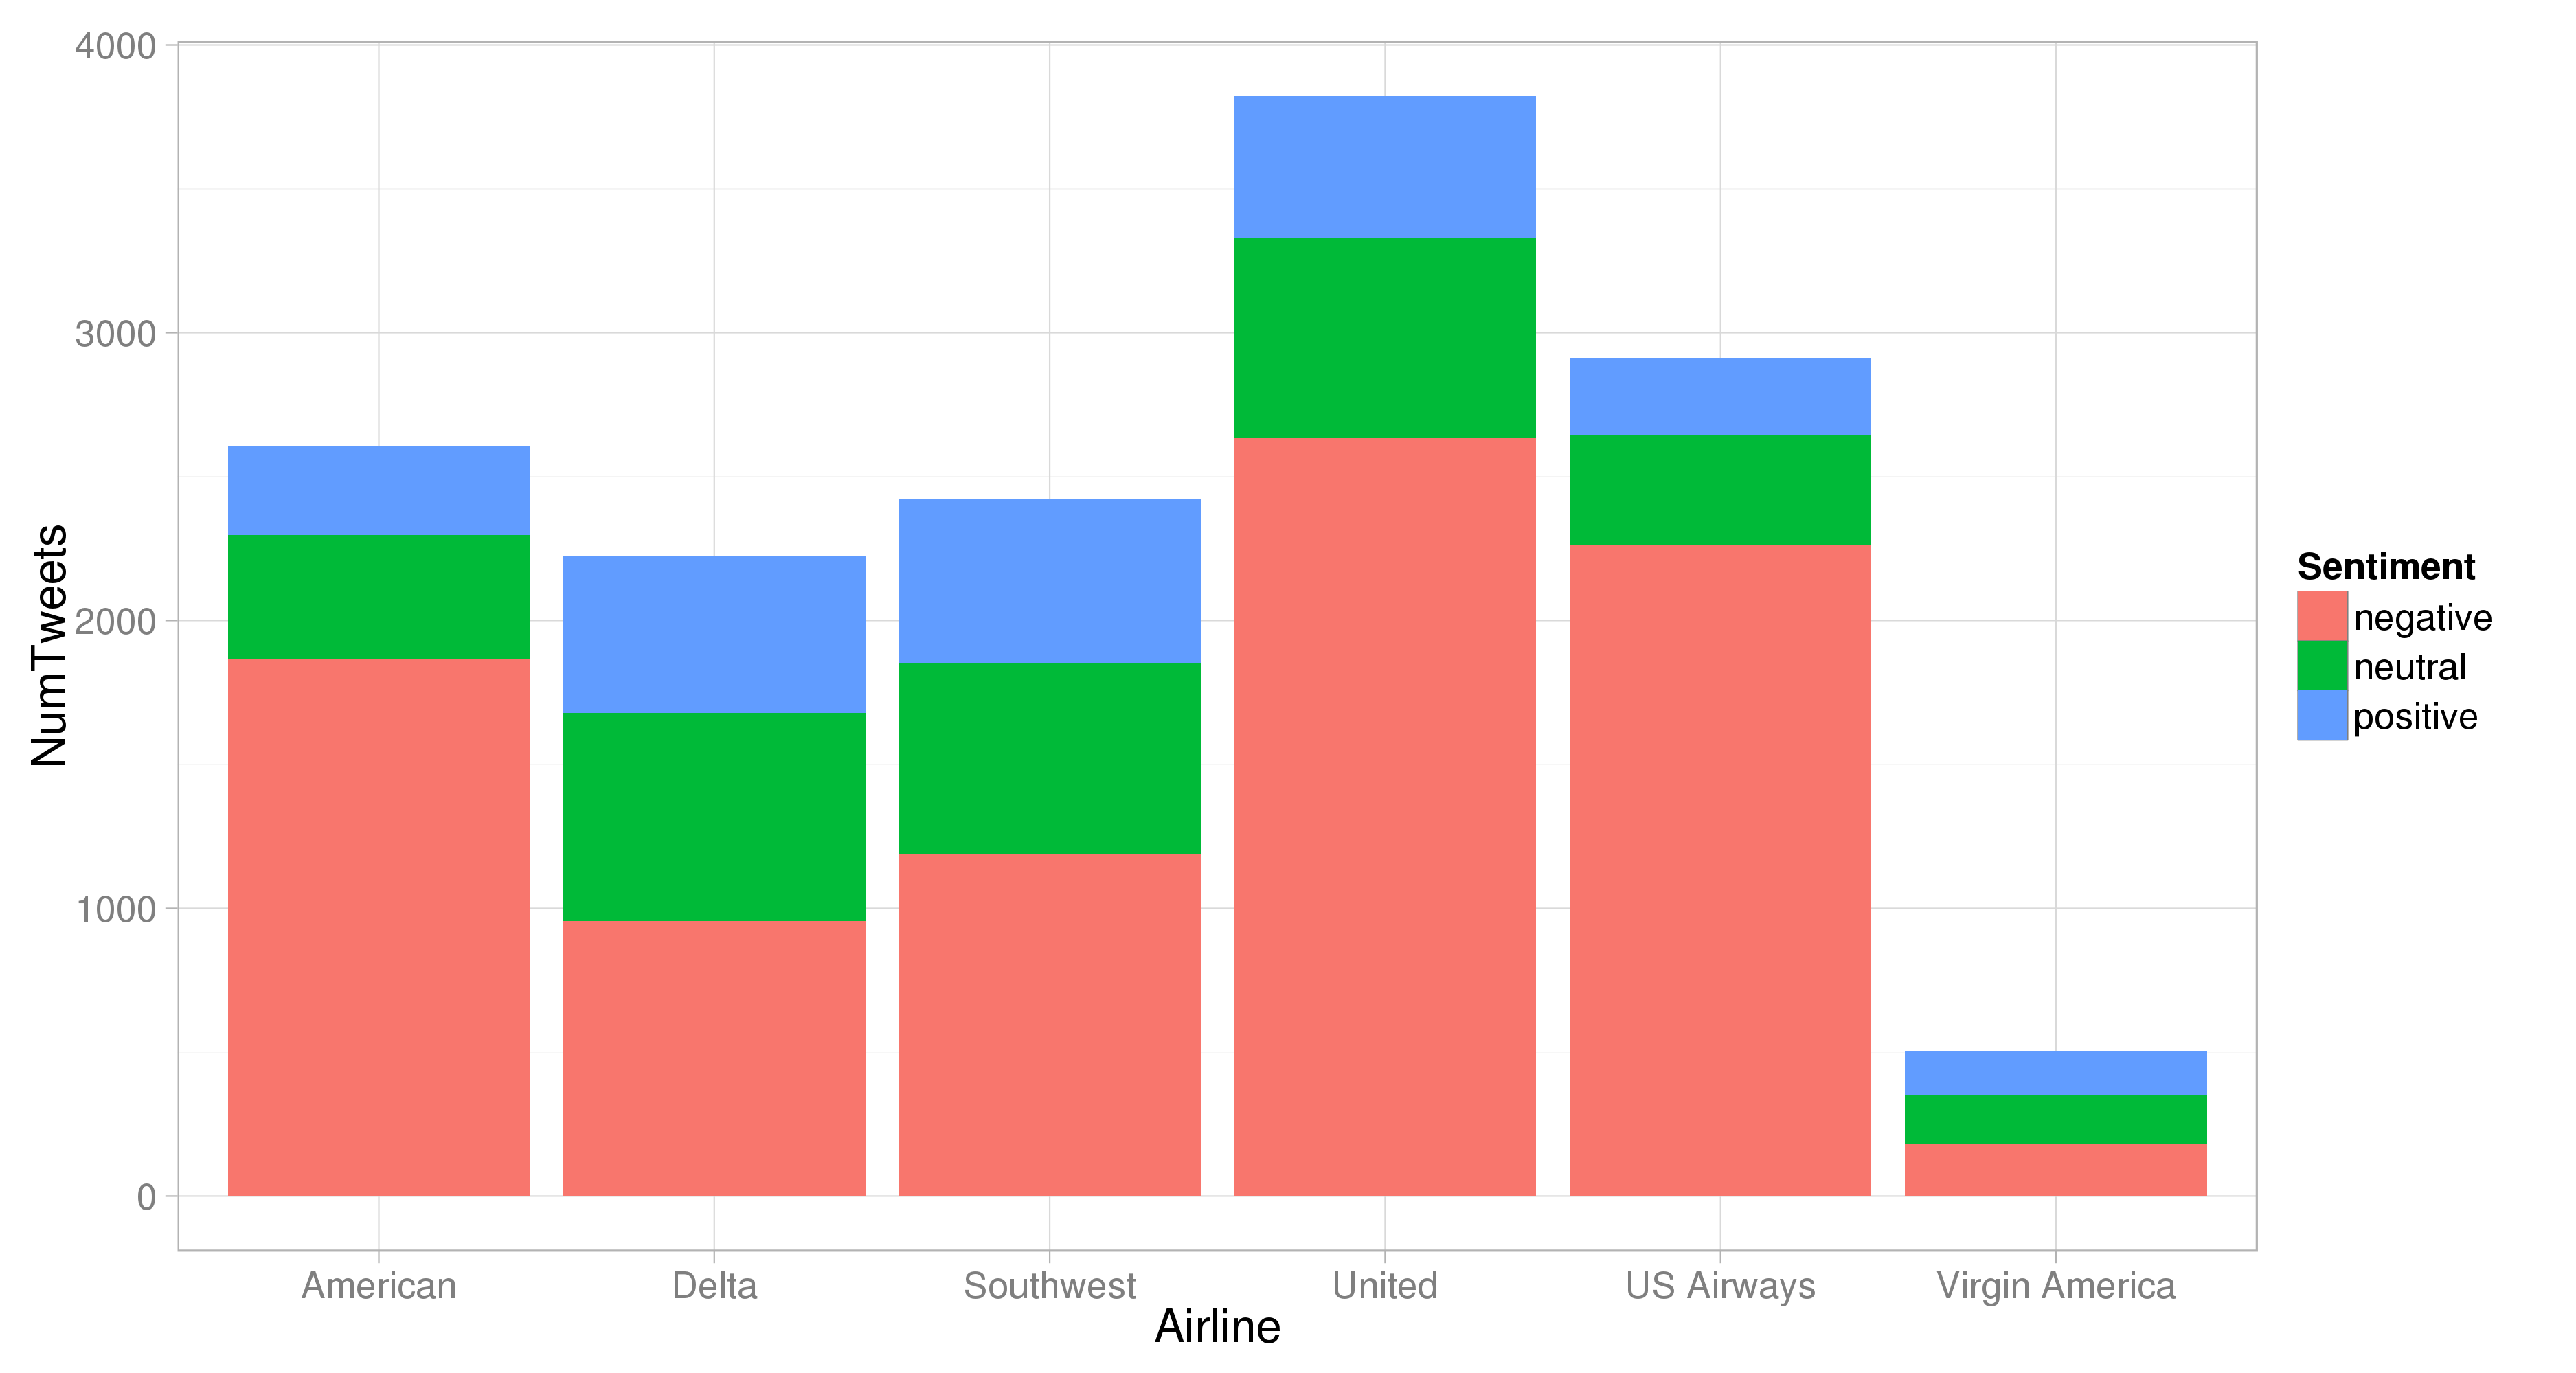

# Project Preperation

## Setup projet -  Import Libray and learners

In [0]:
# Basic packages
import math
import numpy as np
import pandas as pd
import nltk
import re
import string
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline
import collections, numpy
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

pd.set_option('display.max_colwidth', 150)

In [0]:
# Packages for preparation
import nltk
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

import nltk
nltk.download('punkt')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#### Set some parameters

In [0]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent

In [0]:
def merge_classes(airline_sentiment):
  if (airline_sentiment == 'positive') or (airline_sentiment == 'negative'):
    airline_sentiment = 'Non-Neutral' 
  else:
    airline_sentiment = 'Neutral'
  return airline_sentiment

data = pd.read_csv("/content/Tweets.csv", encoding = 'unicode_escape')
data['airline_sentiment'] = data['airline_sentiment'].apply(lambda x: merge_classes(x))

## Clean and augment data

In [0]:
# detect useless attribute and delete
(len(data)-data.count())/len(data)

tweet_id                        0.000000
airline_sentiment               0.000000
airline_sentiment_confidence    0.000000
negativereason                  0.373087
negativereason_confidence       0.281284
airline                         0.000000
airline_sentiment_gold          0.997268
name                            0.000000
negativereason_gold             0.997814
retweet_count                   0.000000
text                            0.000000
tweet_coord                     0.930396
tweet_created                   0.000000
tweet_location                  0.323292
user_timezone                   0.329235
dtype: float64

In [0]:
# find the attributes which contain most of missin value, and delete them

del data['tweet_coord']
del data['airline_sentiment_gold']
del data['negativereason_gold']

### Helper Functions

In [0]:
wn = nltk.WordNetLemmatizer()
def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    text = ''.join(text)
    return text
  
def remove_website(text):
#     text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)#, flags=re.MULTILINE)
    text = re.sub(r"http\S+", "", text)
    return text
  
def remove_punct(text):
    text  = "".join([char.lower() for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

def remove_unicode(text):
    return ' '.join([i for i in text.split() if '\\' not in i])
  
def remove_stopwords(text):
    text = [word for word in text.split() if word not in stopword]
    text = ' '.join(text)
    return text

### Preprocessing

In [0]:
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

nltk.download('wordnet')

def normalizer(tweet):
    only_letters = re.sub("[^a-zA-Z]", " ",tweet) 
    tokens = nltk.word_tokenize(only_letters)[2:]
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    lemmas = " ".join([wordnet_lemmatizer.lemmatize(t) for t in filtered_result])
    return lemmas

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
data['text_rm_web'] = data['text'].apply(lambda x: remove_website(x))
data['finish'] = data.text_rm_web.apply(normalizer)

In [0]:
data[['text','text_rm_web','finish']].head(2)

,text,text_rm_web,finish
0,@VirginAmerica What @dhepburn said.,@VirginAmerica What @dhepburn said.,dhepburn said
1,@VirginAmerica plus you've added commercials to the experience... tacky.,@VirginAmerica plus you've added commercials to the experience... tacky.,added commercial experience tacky


## Data Exploration - playaround with the cleaned data

In [0]:
print("Shape of the dataframe is",data.shape)
print("The number of nulls in each column are \n", data.isna().sum())

Shape of the dataframe is (14640, 14)
The number of nulls in each column are 
 tweet_id                           0
airline_sentiment                  0
airline_sentiment_confidence       0
negativereason                  5462
negativereason_confidence       4118
airline                            0
name                               0
retweet_count                      0
text                               0
tweet_created                      0
tweet_location                  4733
user_timezone                   4820
text_rm_web                        0
finish                             0
dtype: int64


In [0]:
# count the total mood
mood_count = data['airline_sentiment'].value_counts()
mood_count

Non-Neutral    11541
Neutral         3099
Name: airline_sentiment, dtype: int64

Text(0.5, 1.0, 'Count of Moods')

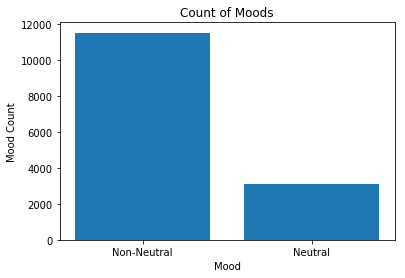

In [0]:
Index = [1,2]
plt.bar(Index,mood_count)
plt.xticks(Index,['Non-Neutral','Neutral'],rotation = 0)
plt.ylabel('Mood Count')
plt.xlabel('Mood')
plt.title('Count of Moods')

### find and plot the distribution of moods for the first three airlines have trends towards non-neutral

### However, the later three airlines are more balanced (2:1)

In [0]:
data['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

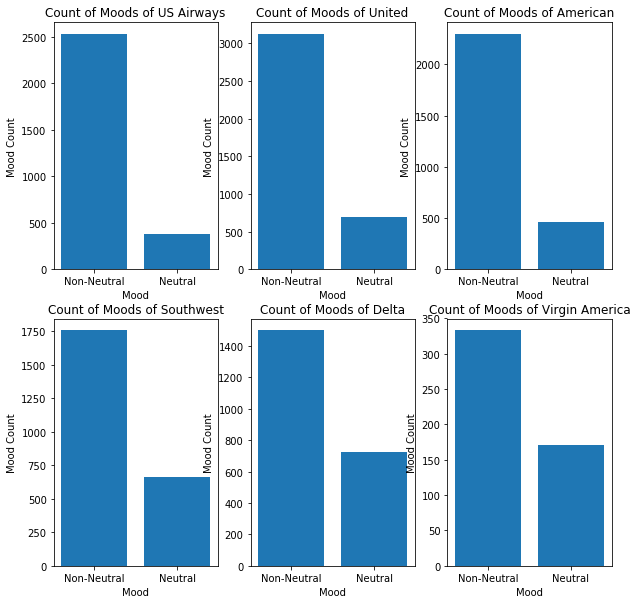

In [0]:
def plot_sub_sentiment(Airline):
    df = data[data['airline'] == Airline]
    count = df['airline_sentiment'].value_counts()
    Index = [1,2]
    plt.bar(Index,count)
    plt.xticks(Index,['Non-Neutral','Neutral'],rotation = 0)
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+ Airline)
plt.figure(1,figsize=(10, 10))
plt.subplot(231)
plot_sub_sentiment('US Airways')
plt.subplot(232)
plot_sub_sentiment('United')
plt.subplot(233)
plot_sub_sentiment('American')
plt.subplot(234)
plot_sub_sentiment('Southwest')
plt.subplot(235)
plot_sub_sentiment('Delta')
plt.subplot(236)
plot_sub_sentiment('Virgin America')

### If the instance has "negativereason" do not equal to Nah, then we can directly label this instance as "Non-Neutral" (negative)

In [0]:
NR_Count = dict(data['negativereason'].value_counts(sort=False))
NR_Count

{'Bad Flight': 580,
 "Can't Tell": 1190,
 'Cancelled Flight': 847,
 'Customer Service Issue': 2910,
 'Damaged Luggage': 74,
 'Flight Attendant Complaints': 481,
 'Flight Booking Problems': 529,
 'Late Flight': 1665,
 'Lost Luggage': 724,
 'longlines': 178}

# Modelling

## Train and test split:

In [0]:
from sklearn.model_selection import train_test_split

# use stratified split
X = pd.DataFrame(data.drop(['airline_sentiment'], axis = 1))
y = data['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

## Build the base model

#### baseline - logistic regression 

In [0]:
# countVectorizer
cver = CountVectorizer()
cv = cver.fit_transform(X_train['finish'])
print('{} Number of tweets has {} words'.format(cv.shape[0], cv.shape[1]))

11712 Number of tweets has 9220 words


In [0]:
clf = LogisticRegression().fit(cv, y_train)
cv_test = cver.transform(X_test['finish'])
cv_test.shape

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(2928, 9220)

In [0]:
y_pred = clf.predict(cv_test)

In [0]:
clf.score(cv_test, y_test)

0.8241120218579235

In [0]:
# most of labels are non-neutral, and it means it predict most of classes 
# as non-neutral
f1_score(y_test, y_pred, pos_label="Neutral", average="binary")

0.49951409135082603

## *From the f1 score above, we can find that both poor precision and poor recall.*

#### baseline - MNB

In [0]:
tv = TfidfVectorizer(sublinear_tf=True)
tfid_train = tv.fit_transform(X_train['finish'].values)
tfid_test = tv.transform(X_test['finish'].values)

In [0]:
clf = MultinomialNB()

history = clf.fit(tfid_train, y_train.values)

## Parameter tuning (if required)

In [0]:
from pprint import pprint
from time import time
import logging

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])

In [0]:
parameters = {
    'tfidf__stop_words':('english',None),
    'tfidf__max_features':(1000,10000,30000,None),
    'tfidf__norm':('l1','l2',None),
    'tfidf__use_idf':(True, False),

    'clf__alpha': (0.00001, 0.000001, 0.0001),

}

In [0]:
grid_search = GridSearchCV(pipeline,
                           parameters,
                           cv=3,
                           scoring='accuracy',
                           n_jobs=-1, 
                           verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()

grid_search.fit(X_train, y_train)

print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

## Evaluation metrics

In [0]:
y_pred_MNB = clf.predict(tfid_test)

acc = accuracy_score(y_pred_MNB, y_test)
print("Acc: {:.2%}".format(acc))

Acc: 80.26%


In [0]:
collections.Counter(y_pred_MNB)

Counter({'Neutral': 72, 'Non-Neutral': 2856})

In [0]:
f1_score(y_test, y_pred_MNB, pos_label="Neutral", average="binary")

0.16473988439306358

## OMG that low f1 score -> pool recall and precision

## Your observation and comments

The low f1 score indicates that both poor precision and poor recall

Since it fail into imbalanced binary class, I used Stratification (if got more time -> Gradient Boosting)

F1 score to measure instead of acc, to find out the true level of the model

# Using pre-trained model (stretch goal)

## Explain the logic behind selecting pre-trained model (for word embedding)
* feed forward NN - 0.912
  * Choose better optimiser and loss function
  * NN -> better fitting ability 
  * from acc to binary cross entropy
  * better activation function (sigmoid to relu)
  
* gloves - 0.78
  * lack of fine tune
  * the way we handle word is not suitable for is not suitable for word emedding
  * conv1D lose a lot of information 
  
if I got time: precess words properly, do some fine tune，make a essemble （stack / voting）

In [0]:
# MLP
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


## Build the model and train on the data set

In [0]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(data['finish'])

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 14640 documents
10000 words in dictionary
Top 5 most common words are: [('flight', 4313), ('get', 1368), ('hour', 1113), ('cancelled', 1016), ('u', 1002)]


In [0]:
X_train_seq = tk.texts_to_sequences(X_train['finish'])
X_test_seq = tk.texts_to_sequences(X_test['finish'])

In [0]:
def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

In [0]:
def neg_reason_trams(neg_reason):
  res = []
  for i in range(len(neg_reason)):
    if str(neg_reason.iloc[i]) == "nan":
      res.append(0)
    else:
      res.append(1)
  return res

In [0]:
neg_reason_train = neg_reason_trams(X_train['negativereason'])
neg_reason_test = neg_reason_trams(X_test['negativereason'])

In [0]:
X_train_final = []
for i in range(len(X_train_oh)):
  temp = X_train_oh[i].tolist()
  temp.append(neg_reason_train[i])
  X_train_final.append(temp)
#del X_train_oh
del neg_reason_train
X_train_final = np.array(X_train_final)

In [0]:
X_test_final = []
for i in range(len(X_test_oh)):
  temp = X_test_oh[i].tolist()
  temp.append(neg_reason_test[i])
  X_test_final.append(temp)

#del X_test_oh
del neg_reason_test
X_test_final = np.array(X_test_final)

In [0]:
y_train_binary = y_train.apply(lambda x: 1 if x=="Neutral" else 0)
y_test_binary = y_test.apply(lambda x: 1 if x=="Neutral" else 0)

In [0]:
from keras import models, layers
model = models.Sequential()
model.add(layers.Dense(16, activation="relu", input_shape=(10001,)))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(rate=0.3))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(rate=0.3))
model.add(layers.Dense(1, activation="sigmoid"))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
from keras import metrics
model.compile(optimizer='rmsprop', loss="binary_crossentropy", metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Evaluation metrics

In [0]:
history = model.fit(
    X_train_final,
    y_train_binary,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_final, y_test_binary)
)

Train on 11712 samples, validate on 2928 samples
Epoch 1/10
11712/11712 [==============================] - 3s 298us/step - loss: 0.2636 - acc: 0.8658 - val_loss: 0.2003 - val_acc: 0.8996
Epoch 2/10
11712/11712 [==============================] - 3s 231us/step - loss: 0.1611 - acc: 0.9273 - val_loss: 0.1899 - val_acc: 0.9119
Epoch 3/10
11712/11712 [==============================] - 3s 239us/step - loss: 0.1372 - acc: 0.9405 - val_loss: 0.2012 - val_acc: 0.9119
Epoch 4/10
11712/11712 [==============================] - 3s 241us/step - loss: 0.1234 - acc: 0.9497 - val_loss: 0.2077 - val_acc: 0.9126
Epoch 5/10
11712/11712 [==============================] - 3s 245us/step - loss: 0.1131 - acc: 0.9541 - val_loss: 0.2023 - val_acc: 0.9105
Epoch 6/10
11712/11712 [==============================] - 3s 246us/step - loss: 0.1042 - acc: 0.9587 - val_loss: 0.2161 - val_acc: 0.9105
Epoch 7/10
11712/11712 [==============================] - 3s 245us/step - loss: 0.0964 - acc: 0.9623 - val_loss: 0.2390 - v

In [0]:
from sklearn.metrics import f1_score
a = []
for i in model.predict(X_test_final):
  if i > 0.5:
    a.append(1)
  else:
    a.append(0)
f1_score(y_test_binary, a)

0.7602441150828249

## Compare with your previous trained model

By using "negative reason" attribute and feed forward NN, I improved the acc and f1 score -> relative high recall and precision 

### Word Embedding

In [0]:
!wget -O "glove.twitter.27B.zip" http://nlp.stanford.edu/data/glove.twitter.27B.zip

--2019-09-29 10:45:55--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2019-09-29 10:45:55--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2019-09-29 10:45:56--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [appli

In [0]:
!unzip "glove.twitter.27B.zip"

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  


In [0]:
def load_emb():
  embeddings_index = {}
  with open("glove.twitter.27B.50d.txt", "r") as f:
    for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype="float32")
      embeddings_index[word] = coefs
  print("found vector", len(embeddings_index))
  return embeddings_index

In [0]:
import os
embedding_index = load_emb()

found vector 1193514


In [0]:
embeddings_dim = 50
embedding_matrix = np.zeros((NB_WORDS, embeddings_dim))
for word,i in tk.word_index.items():
  if i < NB_WORDS:
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [0]:
embedding_matrix.shape

(10000, 50)

In [0]:
from keras import models, layers
model = models.Sequential()
model.add(layers.Embedding(10000, 50, input_length=10000))
model.add(layers.Conv1D(64,3, activation="relu"))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(32,3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(rate=0.3))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(rate=0.3))
model.add(layers.Dense(1, activation="sigmoid"))

In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10000, 50)         500000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 9998, 64)          9664      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4999, 64)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4997, 32)          6176      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [0]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
history = model.fit(
    X_train_oh,
    y_train_binary,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_oh, y_test_binary)
)

Train on 11712 samples, validate on 2928 samples
Epoch 1/10
11712/11712 [==============================] - 313s 27ms/step - loss: 0.5324 - acc: 0.7819 - val_loss: 0.5164 - val_acc: 0.7883
Epoch 2/10
11712/11712 [==============================] - 312s 27ms/step - loss: 1.5996 - acc: 0.7421 - val_loss: 3.3300 - val_acc: 0.7883
Epoch 3/10
10880/11712 [==========================>...] - ETA: 20s - loss: 3.3926 - acc: 0.7813

# Some thoughts on the model

## How do you divide the dataset for training/testing and validation?

By using train_test_split in sklearn.model_selection (ratio 0.2)


## Have you any kind of regularisation, justify your logic.

dropout -> prevent NN formed patterns, which lead to overfitting

rmsprop -> use the default l1 -> regularisation

## What are the further improvements you can make to the model, if you are given more time?

* try feature selection
  filters: PMI(common,good), MI, Chi-square(rare,good)
* Probabliy train multiple ensemble
  * DNN -> collection of words
  * NLP -> training a bag of words


## Final words, about the problem statement.

Be careful of binary imbalanced classification problem